In [ ]:
# !pip install dspy-ai
# import dspy

In [ ]:
!pip install git+https://github.com/stanfordnlp/dspy.git
!pip install -U openai
import openai
!pip install datasets

from datasets import load_dataset

  Cloning https://github.com/stanfordnlp/dspy.git to /tmp/pip-req-build-byld4mq_
  Running command git clone --filter=blob:none --quiet https://github.com/stanfordnlp/dspy.git /tmp/pip-req-build-byld4mq_
  Resolved https://github.com/stanfordnlp/dspy.git to commit 1a2ef1842d4fbde8a2e759e4f537d5177317af8e
  Preparing metadata (setup.py) ... done
  Using cached openai-0.28.1-py3-none-any.whl (76 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.6.1
    Uninstalling openai-1.6.1:
      Successfully uninstalled openai-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


  Using cached openai-1.6.1-py3-none-any.whl (225 kB)
  Attempting uninstall: openai
    Found existing installation: openai 0.28.1
    Uninstalling openai-0.28.1:
      Successfully uninstalled openai-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
dspy-ai 2.0.8 requires openai<=0.28.1, but you have openai 1.6.1 which is incompatible.


In [ ]:
from google.colab import userdata
api_key = userdata.get('api_key')

In [ ]:
import dspy
model=dspy.OpenAI(model='gpt-3.5-turbo', api_key=api_key)

In [ ]:
dspy.settings.configure(lm=model)

In [ ]:
# medqa_dataset = load_dataset("bigbio/med_qa")
# print(medqa_dataset)

In [ ]:
#PubMedQA
# pubmedqa_dataset = load_dataset("bigbio/pubmed_qa")
# print(pubmedqa_dataset)

In [ ]:
#MedMCQA
# medmcqa_dataset = load_dataset("medmcqa")
# print(medmcqa_dataset)

In [ ]:
#MMLU: clinical knowledge, medical genetics, anatomy, professional medicine, college biology, and college medicine. These are the datasets we will be using for our project.
# knowledges = ['clinical_knowledge','medical_genetics','anatomy', 'professional_medicine', 'college_biology', 'college_medicine']
# mmlu_dataset_professional = load_dataset("cais/mmlu",'professional_medicine')

In [ ]:
medqa_dataset = load_dataset("bigbio/med_qa")

#training on the first 20 questions
train_subset = medqa_dataset["train"][:20]

train_questions = train_subset["question"]
train_answers_id = train_subset["answer_idx"]
train_options= train_subset["options"]
train_answer = train_subset["answer"]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/27a6d96c9db3334f9b3c1f99484adac7b7579fe06926d41e9005000368623ad4/data_clean/questions/US/train.jsonl


Generating test split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/27a6d96c9db3334f9b3c1f99484adac7b7579fe06926d41e9005000368623ad4/data_clean/questions/US/test.jsonl


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/27a6d96c9db3334f9b3c1f99484adac7b7579fe06926d41e9005000368623ad4/data_clean/questions/US/dev.jsonl


In [ ]:
# # Data processing
formatted_train_options = [' '.join(f"{option['key']} {option['value']}" for option in options) for options in train_options]
# print(formatted_train_options)

In [ ]:
# # Data processing
# formatted_train_options = []
# for option in train_options:
#   sublist=[]
#   for i in range(len(option)):
#     sublist.append({option[i]['key']: option[i]['value']})
#   formatted_train_options.append(sublist)

In [ ]:
# print(train_questions)
# print(train_options)
# print(train_answer[0])
# print(train_answers_id[0])

['A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient?', 'A 3-month-old baby died suddenly at night while asleep. His mother noticed that he had died only after she awoke in the morning. No cause of death was determined based on the autopsy. Which of the following precautions could have prevented the death of the baby?', "A mother brings her 3-week-old infant to the pediatrician's office because she is concerned about his feeding habits. He was born without complic

In [ ]:
# We are expecting a single choice answer so signature accordingly.
class MultipleChoiceQA(dspy.Signature):
    """Answer questions with single letter answers."""

    question = dspy.InputField(desc="The multiple-choice question.")
    options = dspy.InputField(desc="The set of options in the format : A option1 B option2 C option3 D option4 E option5 where A corresponds to option1, B to option2 and so on.")
    answer = dspy.OutputField(desc="A single-letter answer corresponding to the selected option.")

In [ ]:
class BasicQA(dspy.Signature):
    """Answer questions with short factoid answers."""

    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

In [ ]:
print(train_questions[1])
print(train_options[1])
print(train_answer[1])
print(train_answers_id)

A 3-month-old baby died suddenly at night while asleep. His mother noticed that he had died only after she awoke in the morning. No cause of death was determined based on the autopsy. Which of the following precautions could have prevented the death of the baby?
[{'key': 'A', 'value': 'Placing the infant in a supine position on a firm mattress while sleeping'}, {'key': 'B', 'value': 'Routine postnatal electrocardiogram (ECG)'}, {'key': 'C', 'value': 'Keeping the infant covered and maintaining a high room temperature'}, {'key': 'D', 'value': 'Application of a device to maintain the sleeping position'}, {'key': 'E', 'value': 'Avoiding pacifier use during sleep'}]
Placing the infant in a supine position on a firm mattress while sleeping
['E', 'A', 'A', 'A', 'E', 'C', 'E', 'A', 'E', 'E', 'C', 'D', 'D', 'C', 'D', 'C', 'E', 'D', 'E', 'B']


In [ ]:
# generate_answer = dspy.Predict(MultipleChoiceQA)
# dev_example=train_questions[0]
# pred = generate_answer(question=dev_example,options=formatted_train_options[0])
# print(f"Question: {dev_example}")
# print(f"Predicted Answer: {pred.answer}")

Question: A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient?
Predicted Answer: E


In [ ]:
# generate_answer = dspy.Predict(BasicQA)
# dev_example='What is the capital of India?'
# pred = generate_answer(question=dev_example)
# print(f"Question: {dev_example}")
# print(f"Predicted Answer: {pred.answer}")

Question: What is the capital of India?
Predicted Answer: New Delhi


In [ ]:
# Shuffling the questions.
import random
generate_answer = dspy.Predict(MultipleChoiceQA)

def generate_responses(questions: list[str], option_sets: list[str]) -> list[str]:
    responses = []
    combined_data = list(zip(questions, option_sets))
    random.shuffle(combined_data)
    shuffled_questions, shuffled_option_sets = zip(*combined_data)

    for question, options in zip(shuffled_questions, shuffled_option_sets):
        pred_response = generate_answer(question=question, options=options)
        generated_response = pred_response.answer
        responses.append(generated_response)

    return responses

# def generate_responses(questions, option_sets):
#     responses = []
#     for question, options_list in zip(questions, option_sets):
#         pred_response = generate_answer(question=question, options=options_list)
#         generated_response = pred_response.answer
#         responses.append(generated_response)
#     return responses

In [ ]:
def test_generate_responses():
  assert generate_responses(['What are the symptoms of a headache?'],['A fever B cold C cough D high bp E migraine ']) == ['E']
test_generate_responses()

In [80]:
def calculate_medqa_accuracy(ques, pred: list[str], true: list[str])-> float:
    correct_count = 0

    for p, t in zip(pred, true):
        if p == t:
            correct_count += 1

    accuracy = correct_count / len(pred)
    return accuracy

In [101]:
def validate_answer(ques, pred: list[str], ref: list[str])-> bool:
  for p, t in zip(pred, ref):
    return p==t

In [ ]:
# (question="Which of the following is the primary function of insulin?", options="A. Glycogen breakdown B. Protein synthesis C. Glucose uptake D. Lipid digestion E. Oxygen transport", answer="C"),
# (question="What is the most common cause of acute pancreatitis?", options="A. Alcohol consumption B. Gallstones C. Trauma D. Viral infection E. Genetic predisposition", answer="B"),
# (question="Which of the following is a characteristic finding in rheumatoid arthritis?", options="A. HLA-B27 positivity B. Anti-dsDNA antibodies C. Rheumatoid factor positivity D. Anti-Smith antibodies E. Decreased C-reactive protein", answer="C"),
# (question="In a patient with chronic renal failure, which electrolyte imbalance is commonly observed?", options="A. Hyperkalemia B. Hyponatremia C. Hypocalcemia D. Hyperphosphatemia E. Hypomagnesemia", answer="A"),
# (question="Which class of antibiotics is known to cause irreversible ototoxicity?", options="A. Penicillins B. Cephalosporins C. Aminoglycosides D. Tetracyclines E. Macrolides", answer="C"),
# (question="What is the gold standard diagnostic test for acute appendicitis?", options="A. Ultrasound B. CT scan C. MRI D. X-ray E. Physical examination", answer="B"),
# (question="A patient with a history of frequent sun exposure presents with a nodular, pearly lesion on the face. What is the most likely diagnosis?", options="A. Psoriasis B. Basal cell carcinoma C. Melanoma D. Squamous cell carcinoma E. Rosacea", answer="B"),
# (question="Which hormone is responsible for stimulating milk production in the mammary glands?", options="A. Progesterone B. Prolactin C. Estrogen D. Oxytocin E. Human chorionic gonadotropin (hCG)", answer="B"),
# (question="What is the first-line treatment for status epilepticus?", options="A. Diazepam B. Phenytoin C. Levetiracetam D. Lorazepam E. Phenobarbital", answer="D"),
# (question="A patient presents with chest pain that improves with leaning forward. Which condition is most likely responsible for this symptom?", options="A. Myocardial infarction B. Pericarditis C. Angina pectoris D. Aortic dissection E. Pulmonary embolism", answer="B"),
# question="Which vitamin deficiency is associated with bleeding gums and easy bruising?", options="A. Vitamin A B. Vitamin B12 C. Vitamin C D. Vitamin D E. Vitamin K", answer="C"
# question="In a patient with suspected pulmonary embolism, which imaging modality is preferred for initial evaluation?", options="A. Chest X-ray B. CT pulmonary angiography C. Ventilation-perfusion scan D. Magnetic resonance imaging (MRI) E. Ultrasound", answer="B"
# question="A patient with a history of alcohol abuse presents with confusion, ataxia, and ophthalmoplegia. What is the most likely diagnosis?", options="A. Wernicke's encephalopathy B. Korsakoff syndrome C. Delirium tremens D. Hepatic encephalopathy E. Cerebral contusion", answer="A"
# question="Which of the following is a first-line treatment for hypertension in a patient with diabetes mellitus?", options="A. Atenolol B. Lisinopril C. Hydrochlorothiazide D. Diltiazem E. Clonidine", answer="B"
# question="What is the primary neurotransmitter involved in the pathophysiology of Alzheimer's disease?", options="A. Dopamine B. Acetylcholine C. Serotonin D. Gamma-aminobutyric acid (GABA) E. Norepinephrine", answer="B"
# question="A patient with a history of rheumatic heart disease presents with mitral valve stenosis. Which physical finding is characteristic of this condition?", options="A. Loud S1 heart sound B. Opening snap C. Holosystolic murmur D. Pulsus paradoxus E. Systolic ejection murmur", answer="B"
# question="What is the most common cause of viral myocarditis?", options="A. Coxsackievirus B. Influenza virus C. Human immunodeficiency virus (HIV) D. Herpes simplex virus E. Epstein-Barr virus", answer="A"
# question="Which of the following drugs is contraindicated in patients with a sulfa allergy?", options="A. Cephalexin B. Amoxicillin C. Ciprofloxacin D. Trimethoprim-sulfamethoxazole E. Doxycycline", answer="D"
# question="A patient presents with recurrent episodes of sudden-onset vertigo, hearing loss, and tinnitus. What is the most likely diagnosis?", options="A. Migraine-associated vertigo B. Meniere's disease C. Vestibular neuritis D. Benign paroxysmal positional vertigo (BPPV) E. Labyrinthitis", answer="B"
# question="Which of the following is a characteristic feature of polycystic ovary syndrome (PCOS)?", options="A. Hyperprolactinemia B. Oligomenorrhea C. Hypogonadism D. Amenorrhea E. Increased estrogen levels", answer="B"
# question="A patient with chronic kidney disease is prescribed a phosphate binder. Which medication is commonly used for this purpose?", options="A. Calcium carbonate B. Sevelamer C. Furosemide D. Spironolactone E. Enalapril", answer="B"
# question="What is the classic triad of symptoms in diabetes insipidus?", options="A. Polyuria, polydipsia, weight loss B. Polyuria, polydipsia, hyperglycemia C. Polyuria, polydipsia, hypotension D. Polyuria, polydipsia, hypernatremia E. Polyuria, polydipsia, hypoglycemia", answer="D"
# question="A newborn presents with abdominal distension, vomiting, and failure to pass meconium. What is the most likely diagnosis?", options="A. Intussusception B. Hirschsprung disease C. Pyloric stenosis D. Meconium ileus E. Imperforate anus", answer="D"
# question="Which of the following is a common side effect of angiotensin-converting enzyme (ACE) inhibitors?", options="A. Hyperkalemia B. Hypokalemia C. Hypercalcemia D. Hyponatremia E. Hypoglycemia", answer="A"
# question="A patient with a history of chronic alcohol abuse presents with bleeding tendencies. Which vitamin deficiency is most likely responsible for this clinical manifestation?", options="A. Vitamin A B. Vitamin B12 C. Vitamin C D. Vitamin D E. Vitamin K", answer="E"
# question="What is the first-line treatment for uncomplicated urinary tract infection (UTI) in a non-pregnant woman?", options="A. Ciprofloxacin B. Amoxicillin C. Trimethoprim-sulfamethoxazole D. Nitrofurantoin E. Doxycycline", answer="D"
# question="A patient presents with a severe headache, photophobia, and a positive Brudzinski sign. What is the most likely diagnosis?", options="A. Migraine headache B. Tension-type headache C. Cluster headache D. Subarachnoid hemorrhage E. Sinusitis", answer="D"
# question="Which type of hepatitis is most commonly transmitted through contaminated food and water?", options="A. Hepatitis A B. Hepatitis B C. Hepatitis C D. Hepatitis D E. Hepatitis E", answer="A"
# question="A patient with a history of chronic obstructive pulmonary disease (COPD) presents with increased dyspnea, wheezing, and decreased breath sounds. What is the most likely diagnosis?", options="A. Pneumonia B. Pulmonary embolism C. Pneumothorax D. Asthma exacerbation E. Pleural effusion", answer="C"
# question="Which medication is commonly used as a first-line treatment for acute gout attacks?", options="A. Naproxen B. Allopurinol C. Colchicine D. Methotrexate E. Prednisone", answer="C"

In [102]:
train_set = [dspy.Example(question="Which of the following is the primary function of insulin?", options="A Glycogen breakdown B Protein synthesis C Glucose uptake D Lipid digestion E Oxygen transport", answer="C").with_inputs("question","options"),
dspy.Example(question="What is the most common cause of acute pancreatitis?", options="A Alcohol consumption B Gallstones C Trauma D Viral infection E Genetic predisposition", answer="B").with_inputs("question","options"),
dspy.Example(question="Which of the following is a characteristic finding in rheumatoid arthritis?", options="A HLA-B27 positivity B Anti-dsDNA antibodies C Rheumatoid factor positivity D Anti-Smith antibodies E Decreased C-reactive protein", answer="C").with_inputs("question","options"),
dspy.Example(question="In a patient with chronic renal failure, which electrolyte imbalance is commonly observed?", options="A Hyperkalemia B Hyponatremia C Hypocalcemia D Hyperphosphatemia E Hypomagnesemia", answer="A").with_inputs("question","options"),
dspy.Example(question="Which class of antibiotics is known to cause irreversible ototoxicity?", options="A Penicillins B Cephalosporins C Aminoglycosides D Tetracyclines E Macrolides", answer="C").with_inputs("question","options"),
dspy.Example(question="What is the gold standard diagnostic test for acute appendicitis?", options="A Ultrasound B CT scan C MRI D X-ray E Physical examination", answer="B").with_inputs("question","options"),
dspy.Example(question="A patient with a history of frequent sun exposure presents with a nodular, pearly lesion on the face What is the most likely diagnosis?", options="A Psoriasis B Basal cell carcinoma C Melanoma D Squamous cell carcinoma E Rosacea", answer="B").with_inputs("question","options"),
dspy.Example(question="Which hormone is responsible for stimulating milk production in the mammary glands?", options="A Progesterone B Prolactin C Estrogen D Oxytocin E Human chorionic gonadotropin (hCG)", answer="B").with_inputs("question","options"),
dspy.Example(question="What is the first-line treatment for status epilepticus?", options="A Diazepam B Phenytoin C Levetiracetam D Lorazepam E Phenobarbital", answer="D").with_inputs("question","options"),
dspy.Example(question="A patient presents with chest pain that improves with leaning forward Which condition is most likely responsible for this symptom?", options="A Myocardial infarction B Pericarditis C Angina pectoris D Aortic dissection E Pulmonary embolism", answer="B").with_inputs("question","options")]

In [103]:
class ZERO(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.Predict(MultipleChoiceQA)

    def forward(self, question, options):
        answer = self.generate_answer(question=question,options=options)
        return answer

In [104]:
from dspy.teleprompt import BootstrapFewShot

teleprompter = BootstrapFewShot(metric = validate_answer)
compiled = teleprompter.compile(ZERO(), trainset=train_set)

100%|██████████| 10/10 [00:00<00:00, 891.21it/s]

Bootstrapped 0 full traces after 10 examples in round 0.


In [105]:
def compiled_zero(questions: list[str], option_sets: list[str]) -> list[str]:
    responses = []
    combined_data = list(zip(questions, option_sets))
    random.shuffle(combined_data)
    shuffled_questions, shuffled_option_sets = zip(*combined_data)

    for question, options in zip(shuffled_questions, shuffled_option_sets):
        pred_response = compiled(question=question, options=options)
        generated_response = pred_response.answer
        responses.append(generated_response)

    return responses

In [88]:
compiled("How are you?"," A okay B Fine")

Prediction(
    answer='B'
)

Training - Epoch 1/50, accuracy:0.150 
-------------------------------------------------------------------
Training - Epoch 2/50, accuracy:0.100 
-------------------------------------------------------------------
Training - Epoch 3/50, accuracy:0.150 
-------------------------------------------------------------------
Training - Epoch 4/50, accuracy:0.050 
-------------------------------------------------------------------
Training - Epoch 5/50, accuracy:0.300 
-------------------------------------------------------------------
Training - Epoch 6/50, accuracy:0.200 
-------------------------------------------------------------------
Training - Epoch 7/50, accuracy:0.350 
-------------------------------------------------------------------
Training - Epoch 8/50, accuracy:0.100 
-------------------------------------------------------------------
Training - Epoch 9/50, accuracy:0.250 
-------------------------------------------------------------------
Training - Epoch 10/50, accuracy:0.25

Text(0, 0.5, 'Accuracy')

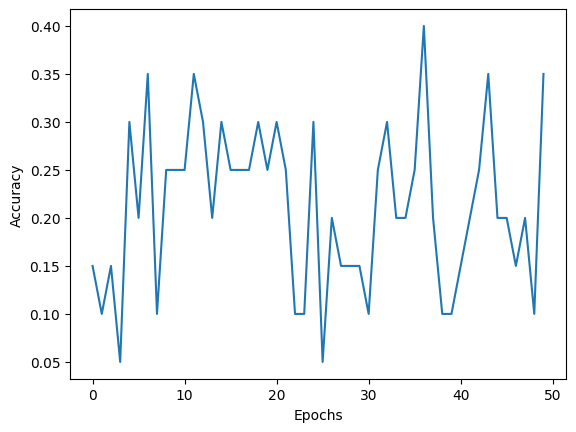

In [106]:
#Zero-shot(directly ask a question and get an answer no prior training.)
#Ignore error API_KEY not added right now.
epochs = 50

accuracy = []

for j in range(epochs):

  generated_responses = compiled_zero(train_questions, formatted_train_options)
  running_accuracy = calculate_medqa_accuracy(train_questions, generated_responses, train_answers_id)
  accuracy.append(running_accuracy)

  print('Training - Epoch {}/{}, accuracy:{:.3f} '.format(j+1, epochs, accuracy[j]))
  print('-------------------------------------------------------------------')

# Line Plot of accuracy vs epochs
import matplotlib.pyplot as plt

plt.plot(range(epochs),accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
model.inspect_history()





Answer questions with single letter answers.

---

Follow the following format.

Question: The multiple-choice question.
Options: The set of options in the format : A option1 B option2 C option3 D option4 E option5 where A corresponds to option1 and so on.
Answer: A single-letter answer corresponding to the selected option.

---

Question: A 23-year-old man comes to the physician for evaluation of decreased hearing, dizziness, and ringing in his right ear for the past 6 months. Physical examination shows multiple soft, yellow plaques and papules on his arms, chest, and back. There is sensorineural hearing loss and weakness of facial muscles bilaterally. His gait is unsteady. An MRI of the brain shows a 3-cm mass near the right internal auditory meatus and a 2-cm mass at the left cerebellopontine angle. The abnormal cells in these masses are most likely derived from which of the following embryological structures?
Options: A Neural tube B Surface ectoderm C Neural crest D Notochord 